### This notebook is answer the question: How much technical lag is induced by direct dependencies?

In [ ]:
%matplotlib inline
import seaborn as sns; #sns.set(style="ticks", color_codes=True)
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import scipy
style.use('fast')

sns.set_style('ticks',{'legend.frameon':True} )
sns.set_palette('colorblind')

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['text.usetex'] = True

plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22
plt.rcParams['axes.labelsize']= 22

PALETTE_BASE = sns.color_palette('muted', n_colors=12)
blue=PALETTE_BASE[0]
green=PALETTE_BASE[1] 
red=PALETTE_BASE[2] 
purple=PALETTE_BASE[3]
version_colors=['orange',red, 'gray']

exclude_prefixes = ('@ryancavanaugh/pkg', 'all-packages-', 'cool-', 'neat-', 'wowdude-', 'npmdoc-', 'npmtest-', 'npm-ghost-',)
exclude_suffixes = ('-cdn',)
exclude_ghost = r'^ghost-\d+$'

In [2]:
# This is a helped to compute Cliff's Delta
from __future__ import division
 
def cliffsDelta(lst1,lst2,
                dull = [0.147, # small
                        0.33,  # medium
                        0.474 # large
                        ][0] ): 
  "Returns true if there are more than 'dull' differences"
  m, n = len(lst1), len(lst2)
  lst2 = sorted(lst2)
  j = more = less = 0
  for repeats,x in runs(sorted(lst1)):
    while j <= (n - 1) and lst2[j] <  x: 
      j += 1
    more += j*repeats
    while j <= (n - 1) and lst2[j] == x: 
      j += 1
    less += (n - j)*repeats
  d= (more - less) / (m*n)
  f=abs(d)  > dull
  print("d="+str(d))#+' '+str(f))
  return abs(d)  > dull
   
def runs(lst):
  "Iterator, chunks repeated values"
  for j,two in enumerate(lst):
    if j == 0:
      one,i = two,0
    if one!=two:
      yield j - i,one
      i = j
    one=two
  yield j - i + 1,two
  
def _cliffsDelta():
  "demo function"
  lst1=[1,2,3,4,5,6,7]
  for r in [1.01,1.1,1.21, 1.5, 2]:
    lst2=map(lambda x: x*r,lst1)

# RQ1

In [ ]:
# Considered period for the analysis
first_date="2010-12-20"
last_date="2018-03-12"
date_period = pd.to_datetime(first_date), pd.to_datetime(last_date)

In [ ]:
# Load data
dep_lag = pd.read_csv('../../../jsep2018/csv/packages/technical_lag_clean.csv', 
                    usecols=['package','version','version_lag','kind','date'],
                          sep=';', dtype=object, index_col=None,  error_bad_lines=False)
print(len(dep_lag))
dep_lag.head(2)

In [4]:
# Filter out pre-releases
dep_lag = dep_lag[~dep_lag.version.str.contains('-')]

In [5]:
# Filter out spam packages
dep_lag = dep_lag[~dep_lag['package'].str.startswith(exclude_prefixes)]
dep_lag = dep_lag[~dep_lag['package'].str.endswith(exclude_suffixes)]
dep_lag = dep_lag[~dep_lag['package'].str.match(exclude_ghost)]

In [6]:
len(dep_lag)

45178989

In [7]:
print(len(dep_lag.query('version_lag=="0,0,0"')),
      len(dep_lag.query('version_lag!="0,0,0"')))

33511815 11667174


In [8]:
# Proportion outdated dependencies
len(dep_lag.query('version_lag!="0,0,0"'))/len(dep_lag)

0.2582433617538454

In [9]:
dep_lag.query('version_lag!="0,0,0"').groupby('kind').count()[['package']]/len(dep_lag.query('version_lag!="0,0,0"'))

,package
kind,
Development,0.680696
Optional,0.000010
runtime,0.319294


In [10]:
dep_lag.query('version_lag!="0,0,0"').groupby('kind').count()[['package']]

,package
kind,
Development,7941801
Optional,116
runtime,3725257


In [11]:
dep_lag.query('version_lag=="0,0,0"').groupby('kind').count()[['package']]/len(dep_lag.query('version_lag=="0,0,0"'))

,package
kind,
Development,0.541823
Optional,0.000005
runtime,0.458172


In [12]:
dep_lag.query('version_lag=="0,0,0"').groupby('kind').count()[['package']]

,package
kind,
Development,18157468
Optional,162
runtime,15354185


### Outdated Packages

### Time lag
This part is to anlayze the evolution of the time lag

In [15]:
# we filter out depndencies with technical lag = 0
dep_lag = dep_lag.query('version_lag!="0,0,0"')

In [16]:
dep_lag['date_used_version']=pd.to_datetime(dep_lag['date_used_version'])
dep_lag['date_last_available']=pd.to_datetime(dep_lag['date_last_available'])

In [24]:
# Compute time lag
dep_lag['time_lag']=dep_lag['date_last_available'] - dep_lag['date_used_version']

In [28]:
time_lag=dep_lag[['package','version','date','kind','time_lag']]
time_lag['time_lag']=time_lag['time_lag'].apply(lambda x : float(str(x).split()[0]))

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [29]:
time_lag = time_lag.query('time_lag != 0') # Some package versions may have been created the same day
time_lag['date']=pd.to_datetime(time_lag['date'])

In [30]:
# We aggregate version lag by max
time_lag_max=time_lag.groupby(['package','version','kind','date']).agg('max').reset_index()
len(time_lag_max)

2899421

In [31]:
time_lag_max['date']=pd.to_datetime(time_lag_max['date'])
time_lag_max['time_lag']=time_lag_max['time_lag'].apply(float)


In [32]:
# Statistical test for the difference between time lag for Dev and Runtime dependencies.
scipy.stats.mannwhitneyu(time_lag_max.query('kind=="Development"').time_lag,time_lag_max.query('kind=="runtime"').time_lag)

MannwhitneyuResult(statistic=947904848760.0, pvalue=0.0)

In [35]:
# Cliff's delta for the difference between time lag for Dev and Runtime dependencies.
cliffsDelta(time_lag_max.query('kind=="Development"').time_lag,time_lag_max.query('kind=="runtime"').time_lag)

d=0.07440429288927344


False

In [36]:
time_lag_max.query('time_lag!=0').query('kind=="runtime"').time_lag.median()

160.0

In [37]:
time_lag_max.query('time_lag!=0').query('kind=="Development"').time_lag.median()

195.0

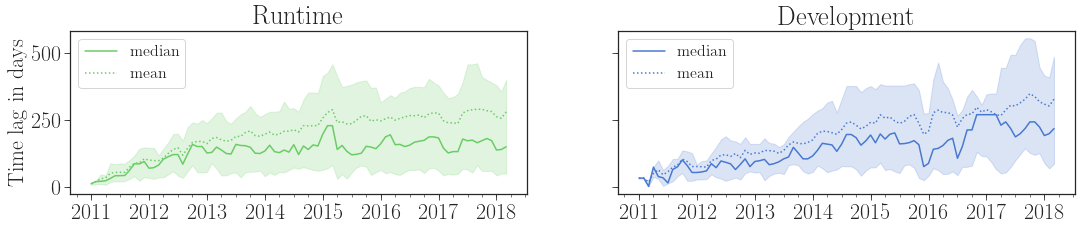

In [41]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_size_inches(18,3)
for index, genre in enumerate(['runtime','Development']):
    size=[12,20,70]
    df_=(time_lag_max.
         query('time_lag!=0').
         query('kind=="{}"'.format(genre)).
         groupby(pd.Grouper(key='date', freq='1M'))['time_lag'].
         describe()[['mean', '25%', '50%', '75%']] 
        )
    genre=genre.capitalize()
    if genre =="Runtime":
        color=green
    else:
        color=blue

    df_tmp=df_
    df_tmp['50%'].rename('median').plot(ax=axes[index], color=color)
    ax=df_tmp['mean'].plot(ax=axes[index],style=':',color=color)
    ax.fill_between(df_tmp.index, df_tmp['25%'], df_tmp['75%'], alpha=0.2, color=color)

    ax.set(
        xlabel='',
        ylabel='Time lag in days'.format(genre),
        title=genre
    )
    ax.legend(loc='upper left',  prop={'size': 16, 'weight':'bold'})
#fig.savefig('../../../../repositories/jsep18technicallag/figures/time_lag.png', bbox_inches='tight', facecolor='white')


In [46]:
# Statitiscal tests to compare the whole periode
for x in range(2010, 2018):
    first=str(x)
    last=str(x+1)
    a=time_lag_max.query('date>"'+first+'" and date<"'+last+'"')
    print(first,last)
    print( scipy.stats.mannwhitneyu(a.query('kind=="Development"').time_lag,
                                    a.query('kind=="runtime"').time_lag))

2010 2011
MannwhitneyuResult(statistic=0.0, pvalue=0.0)
2011 2012
MannwhitneyuResult(statistic=2299946.5, pvalue=0.44433028424297838)
2012 2013
MannwhitneyuResult(statistic=55585013.5, pvalue=5.2786163179451937e-82)
2013 2014
MannwhitneyuResult(statistic=845536881.0, pvalue=3.2392602577436822e-145)
2014 2015


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:4897: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


MannwhitneyuResult(statistic=6330515524.5, pvalue=7.8253155146745007e-45)
2015 2016
MannwhitneyuResult(statistic=22328043682.5, pvalue=0.055973442411739217)
2016 2017
MannwhitneyuResult(statistic=72090711169.5, pvalue=6.0207044605379801e-54)
2017 2018
MannwhitneyuResult(statistic=158630582656.5, pvalue=0.0)


In [59]:
# Cliff's Dela to compare the whole periode
for b in range(2011,2018):
    first=str(b)
    last=str(b+1)
    a=time_lag_max.query('date>"'+first+'" and date<"'+last+'"')
    print(first,last)
    print(cliffsDelta(a.query('kind=="Development"').time_lag,
                                    a.query('kind=="runtime"').time_lag))

2011 2012
d=0.002520429290497962
False
2012 2013
d=-0.14768304703888357
True
2013 2014
d=-0.10051361198376367
False
2014 2015
d=0.0337858769730778
False
2015 2016
d=0.0028246304357184035
False
2016 2017
d=0.020516406544691303
False
2017 2018
d=0.1264832970181366
False


### Version lag
This part is to anlayze the evolution of the version lag

In [ ]:
# Only dependencies with version lag != 0
version_lag_sum=dep_lag.query('version_lag!="0,0,0"')[['package','version','version_lag','date','kind']]
len(version_lag_sum)/len(dep_lag)

In [65]:
# Split the version lag triple to three components
version_lag_sum=(version_lag_sum.
                 assign(version_major=lambda d: d['version_lag'].apply(lambda x: int(x.split(',')[0])) ).
                 assign(version_minor=lambda d: d['version_lag'].apply(lambda x: int(x.split(',')[1]))  ).
                 assign(version_patch=lambda d: d['version_lag'].apply(lambda x: int(x.split(',')[2])) )
                )         

In [66]:
version_lag_sum.drop('version_lag', axis=1, inplace=True)

In [67]:
# We aggregate version lag by addition
version_lag_sum=version_lag_sum.groupby(['package','version','date','kind']).agg('sum')
version_lag_sum.reset_index(inplace=True)

In [68]:
# Prepare fot the visualization
version_lag_sum['date']=pd.to_datetime(version_lag_sum['date'])
version_lag_sum.rename(columns={'version_major':'Major','version_minor':'Minor','version_patch':'Patch'}, inplace=True)
for x in ['Minor','Patch','Major']:
    version_lag_sum[x]=version_lag_sum[x].apply(float)
version_lag_sum['kind']=version_lag_sum['kind'].apply(lambda x: x.capitalize())
version_lag_sum.head(2)

,package,version,date,kind,Major,Minor,Patch
0,0-,0.0.1,2017-03-06,Development,4.0,4.0,13.0
1,0-9,0.0.1,2017-03-06,Development,4.0,4.0,13.0


In [70]:
for kind in ['Development','Runtime']:
    dd=version_lag_sum.query('kind=="'+kind+'"')
    print(kind)
    print(dd.Major.median(),dd.Minor.median(),dd.Patch.median())

Development
2.0 2.0 9.0
Runtime
1.0 1.0 4.0


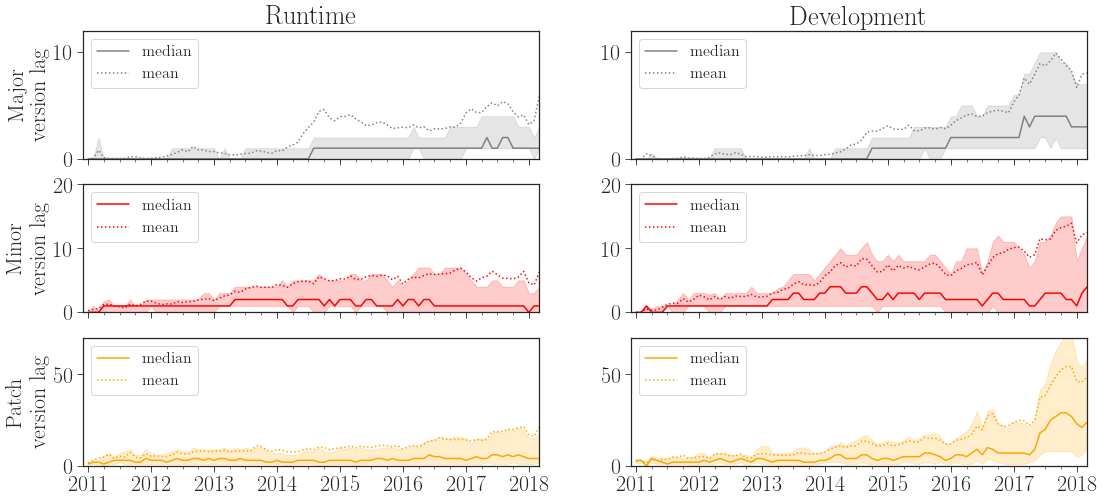

In [74]:
fig, axes = plt.subplots(3, 2, sharex=True, sharey=False)
fig.set_size_inches(18,8)
for index, genre in enumerate(['Runtime','Development']):
    size=[12,20,70]
    dfs={}
    for x in ['Patch','Minor','Major']:
        dfs[x]=(version_lag_sum.query('kind=="{}"'.format(genre)).
                groupby(pd.Grouper(key='date', freq='1M'))[x].
                describe()[['mean', '25%', '50%', '75%']] 
               )

    colors={}
    colors['Patch']='orange'
    colors['Minor']='r'
    colors['Major']='gray'


    for i, x in enumerate(['Major','Minor','Patch']):
        #fig, ax = plt.subplots()
        df_tmp=dfs[x]
        df_tmp['50%'].rename('median').plot(ax=axes[i][index], color=colors[x])
        df_tmp['mean'].plot(style=':',ax=axes[i][index], color=colors[x])
        axes[i][index].fill_between(df_tmp.index, df_tmp['25%'], df_tmp['75%'], color=colors[x], alpha=0.2)

        axes[i][index].set(
            xlabel='',
            ylabel='{} \n version lag'.format(x),
            xlim=date_period,
            ylim=(0,size[i]),
        )
        if i == 0:
            axes[i][index].set(title=genre)
        if index==1:
            axes[i][index].set(ylabel='')

        axes[i][index].legend(loc='upper left',  prop={'size': 16, 'weight':'bold'})

fig.savefig('../../../../repositories/jsep18technicallag/figures/version_lag.pdf', bbox_inches='tight', facecolor='white')

# Remove O.y.z
Here we do the same analysis but without considering version with major version 0

In [110]:
version_lag_sum=dep_lag.query('version_lag!="0,0,0"')
len(version_lag_sum)/len(dep_lag)

0.19322459239474268

In [111]:
version_lag_sum['zero']=version_lag_sum['used_version'].apply(lambda x: 'True' if x.split('.')[0]=="0"
                                                             else 'False')

In [112]:
version_lag_sum=version_lag_sum.query('zero=="False"')[['package','version','version_lag','date','kind']]

In [113]:
version_lag_sum=(version_lag_sum.
                 assign(version_major=lambda d: d['version_lag'].apply(lambda x: int(x.split(',')[0])) ).
                 assign(version_minor=lambda d: d['version_lag'].apply(lambda x: int(x.split(',')[1]))  ).
                 assign(version_patch=lambda d: d['version_lag'].apply(lambda x: int(x.split(',')[2])) )
                )
                 

In [114]:
version_lag_sum.drop(['version_lag'], axis=1, inplace=True)

In [115]:
version_lag_sum=version_lag_sum.groupby(['package','version','date','kind']).agg('sum')
version_lag_sum.reset_index(inplace=True)

In [117]:
version_lag_sum_zeros['date']=pd.to_datetime(version_lag_sum_zeros['date'])
version_lag_sum_zeros.rename(columns={'version_major':'Major','version_minor':'Minor','version_patch':'Patch'}, inplace=True)
for x in ['Minor','Patch','Major']:
    version_lag_sum_zeros[x]=version_lag_sum_zeros[x].apply(float)
version_lag_sum_zeros['kind']=version_lag_sum_zeros['kind'].apply(lambda x: x.capitalize())
version_lag_sum_zeros.head(2)

,package,version,date,kind,Major,Minor,Patch
0,0-,0.0.1,2017-03-06,Development,4.0,4.0,13.0
1,0-9,0.0.1,2017-03-06,Development,4.0,4.0,13.0


In [ ]:
fig, axes = plt.subplots(3, 2, sharex=True, sharey=False)
fig.set_size_inches(18,8)
for index, genre in enumerate(['Runtime','Development']):
    size=[12,20,70]
    dfs={}
    for x in ['Patch','Minor','Major']:
        dfs[x]=(version_lag_sum_zeros.query('kind=="{}"'.format(genre)).
                groupby(pd.Grouper(key='date', freq='1M'))[x].
                describe()[['mean', '25%', '50%', '75%']] 
               )

    colors={}
    colors['Patch']='orange'
    colors['Minor']='r'
    colors['Major']='gray'


    for i, x in enumerate(['Major','Minor','Patch']):
        df_tmp=dfs[x]
        df_tmp['50%'].rename('median').plot(ax=axes[i][index], color=colors[x])
        df_tmp['mean'].plot(style=':',ax=axes[i][index], color=colors[x])
        axes[i][index].fill_between(df_tmp.index, df_tmp['25%'], df_tmp['75%'], color=colors[x], alpha=0.2)

        axes[i][index].set(
            xlabel='',
            ylabel='{} \n version lag'.format(x),
            xlim=date_period,
            ylim=(0,size[i]),
        )
        if i == 0:
            axes[i][index].set(title=genre)
        if index==1:
            axes[i][index].set(ylabel='')

        axes[i][index].legend(loc='upper left',  prop={'size': 16, 'weight':'bold'})

#fig.savefig('../../../../jsep18technicallag/figures/version_lag_no_caret.png', bbox_inches='tight', facecolor='white')

# Analysis on 0.x.y package versions
Using the dataframe of package versions, we analyze the evolution of package versions with major number 0

In [29]:
versions['zero']=versions['version'].apply(lambda x: 'True' if x.split('.')[0]=="0"
                                       else 'False')

In [30]:
versions['date']=versions['date'].apply(lambda x: x.split('-')[0]+'-'+x.split('-')[1])
versions['date']=pd.to_datetime(versions['date'])

In [52]:
if True: # If the datafarme was not loaded before
    dep_lag=pd.read_csv('../../../jsep2018/csv/packages/technical_lag_clean.csv',
                          sep=';', dtype=object, index_col=None,  error_bad_lines=False)

51351426


In [42]:
mask= versions.package.isin(dep_lag.dependency.drop_duplicates())
versions=versions[mask]

In [43]:
aaaaa=versions.groupby(['zero','date']).count()[['version']].reset_index()
aaaaa2=versions.groupby(['date']).count()[['package']].reset_index()

In [44]:
aaaaa=(aaaaa.
    pivot(index='date', columns='zero', values='version').
     fillna(0)
    ).reset_index()

In [46]:
aaaaa3=(aaaaa.
       merge(aaaaa2,
             left_on='date',
             right_on='date',
             how='left')
       .fillna(0)
       .reset_index()
      )

In [47]:
aaaaa3['initial']=aaaaa3['True']/aaaaa3['package']
aaaaa3['major']=aaaaa3['False']/aaaaa3['package']
aaaaa3.rename(columns={'initial':'0.y.z', 'major':'other'}, inplace=True)

(0, 1)

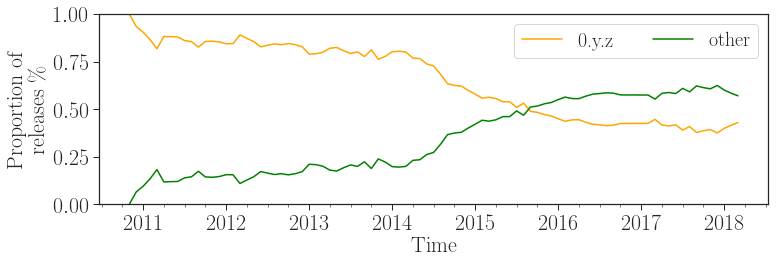

In [49]:
ax=aaaaa3.query('date!="1970-01-01"')[['date','0.y.z','other']].plot(x="date", color=['orange','green'])#, ax=axes[int(i/2)][j], label=type)    

ax.set_ylabel('Proportion of\n releases \%')
ax.set_xlabel('Time')
ax.figure.set_size_inches(12,3.5)
plt.tick_params(axis='both', which='major', width=1)
ax.legend( prop={'size': 20, 'weight':'bold'}, ncol=3, bbox_to_anchor=(1, 1))
ax.set_ylim(0,1)
#ax.figure.savefig('/home/neglectos/Desktop/jsep18technicallag/figures/version_zero.png', bbox_inches='tight', facecolor='white')

In [50]:
# Check the proportion in a specific date
aaaaa3.query('date=="2014-01-01"')

,index,date,False,True,package,0.y.z,other
39,39,2014-01-01,2461.0,9957.0,12416,0.801949,0.198212


In [51]:
# Check the proportion in a specific date
aaaaa3.query('date=="2015-01-01"')

,index,date,False,True,package,0.y.z,other
51,51,2015-01-01,9213.0,12683.0,21888,0.57945,0.420916
